# Single step image generation using SDXL-turbo and OpenVINO

SDXL-Turbo is a fast generative text-to-image model that can synthesize photorealistic images from a text prompt in a single network evaluation. SDXL-Turbo is a distilled version of [SDXL 1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0), trained for real-time synthesis. 
SDXL Turbo is based on a novel distillation technique called Adversarial Diffusion Distillation (ADD), which enables the model to synthesize image outputs in a single step and generate real-time text-to-image outputs while maintaining high sampling fidelity. More details about this distillation approach can be found in [technical report](https://stability.ai/research/adversarial-diffusion-distillation). More details about model can be found in [Stability AI blog post](https://stability.ai/news/stability-ai-sdxl-turbo).

Previously, we already discussed how to launch Stable Diffusion XL model using OpenVINO in the following [notebook](../stable-diffusion-xl), in this tutorial we will focus on the [SDXL-turbo](https://huggingface.co/stabilityai/sdxl-turbo) version. Additionally, to improve image decoding speed, we will use [Tiny Autoencoder](https://github.com/madebyollin/taesd), which is useful for real-time previewing of the SDXL generation process.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format. For running the image generation we will use [OpenVINO GenAI](https://github.com/openvinotoolkit/openvino.genai) that provides easy-to-use API.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model to OpenVINO format](#Convert-model-to-OpenVINO-format)
- [Text-to-image generation](#Text-to-image-generation)
    - [Select inference device for text-to-image generation](#Select-inference-device-for-text-to-image-generation)
- [Image-to-Image generation](#Image-to-Image-generation)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
        - [Compare UNet file size](#Compare-UNet-file-size)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/sdxl-turbo/sdxl-turbo.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q -U --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly "openvino>=2024.5" "openvino-genai>=2024.5"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "torch>=2.1" transformers "diffusers>=0.24.0" "git+https://github.com/huggingface/optimum-intel.git" "gradio>=4.19" "peft>=0.6.2" "nncf>=2.14.0"

## Convert model to OpenVINO format
[back to top ⬆️](#Table-of-contents:)


[sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). We will use optimum-cli interface for exporting it into OpenVINO Intermediate Representation (IR) format.

 Optimum CLI interface for converting models supports export to OpenVINO (supported starting optimum-intel 1.12 version).
General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. Available tasks depend on the model, for sdxl should be selected `stable-diffusion-xl` 

You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager).

Additionally, you can specify weights compression `--weight-format` for the model compression. Please note, that for INT8/INT4, it is necessary to install nncf.

Full list of supported arguments available via `--help`
For more details and examples of usage, please check [optimum documentation](https://huggingface.co/docs/optimum/intel/inference#export).

For Tiny Autoencoder, we will use `ov.convert_model` function for obtaining `ov.Model` and save it using `ov.save_model`. Model consists of 2 parts that used in pipeline separately:
`vae_encoder` for encoding input image in latent space in image-to-image generation task and `vae_decoder` that responsible for decoding diffusion result back to image format.

In [ ]:
from pathlib import Path
import requests


if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("sdxl-turbo.ipynb")

model_dir = Path("./model")
sdxl_model_id = "stabilityai/sdxl-turbo"
tae_id = "madebyollin/taesdxl"
skip_convert_model = model_dir.exists()

In [ ]:
import gc

import torch
from diffusers import AutoencoderTiny
import openvino as ov

from cmd_helper import optimum_cli


class VAEEncoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, sample):
        return {"latent_sample": self.vae.encode(x=sample)["latents"]}


def convert_tiny_vae(model_id, output_path):
    tiny_vae = AutoencoderTiny.from_pretrained(model_id)
    tiny_vae.eval()
    vae_encoder = VAEEncoder(tiny_vae)
    ov_model = ov.convert_model(vae_encoder, example_input=torch.zeros((1, 3, 512, 512)))
    ov.save_model(ov_model, output_path / "vae_encoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_encoder")


if not skip_convert_model:
    optimum_cli(sdxl_model_id, model_dir, additional_args={"weight-format": "fp16"})
    convert_tiny_vae(tae_id, model_dir)

## Text-to-image generation
[back to top ⬆️](#Table-of-contents:)


Text-to-image generation lets you create images using text description. To start generating images, we need to load models first.
We will use [OpenVINO GenAI](https://github.com/openvinotoolkit/openvino.genai) that provides easy-to-use API for running text generation. Firstly we will create pipeline with `Text2ImagePipeline` and `Image2ImagePipeline`. You can see more details in [Image Python Generation Pipeline Example](https://github.com/openvinotoolkit/openvino.genai/tree/releases/2025/0/samples/python/image_generation)
Then we just run `generate` method and get the image tokens and then convert them into the image using `Image.fromarray` from PIL.

### Select inference device for text-to-image generation
[back to top ⬆️](#Table-of-contents:)


In [4]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [5]:
import openvino_genai as ov_genai


text2image_pipe = ov_genai.Text2ImagePipeline(model_dir, device.value)

We should provide text prompt. The default number of steps is 50, while sdxl-turbo required only 1 step. According to the information provided in model card, model does not use negative prompt and guidance scale and this parameters should be disabled using  `guidance_scale = 0`

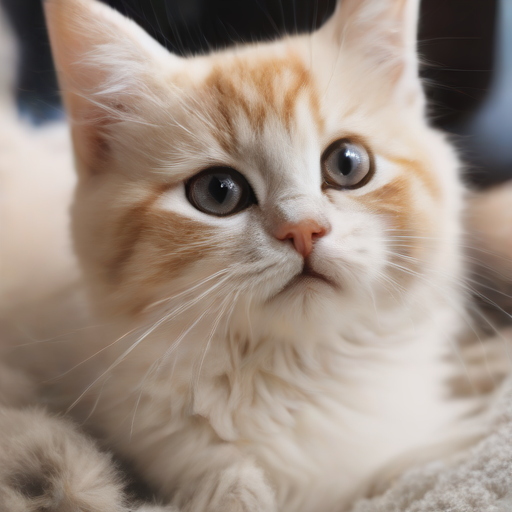

In [6]:
import numpy as np
from PIL import Image


prompt = "cute cat"
image_tensor = text2image_pipe.generate(
    prompt,
    num_inference_steps=1,
    height=512,
    width=512,
    guidance_scale=0.0,
    generator=ov_genai.TorchGenerator(987),
)
image = Image.fromarray(image_tensor.data[0])
image.save("cat.png")
image

In [7]:
del text2image_pipe
gc.collect();

## Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)


Image-to-image generation lets you transform images to match the characteristics provided in the text description. We can reuse the already converted model for running the Image2Image generation pipeline. For that, we should replace `OVStableDiffusionXLPipeline` with `Image2ImagePipeline`. Also we convert the input image to `ov.Tensor` using `image_to_tensor` function. 

In [8]:
image2image_pipe = ov_genai.Image2ImagePipeline(model_dir, device=device.value)

`strength` parameter is important for the image-to-image generation pipeline. It is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input, then close to 0, less noise will be added and the target image will preserve source image content. strength has an impact not only on a number of noise but also the number of generation steps. The number of denoising iterations in the image-to-image generation pipeline is calculated as `int(num_inference_steps * strength)`. With sdxl-turbo we should be careful with selecting `num_inference_steps` and `strength` to produce the correct result and make sure that the number of steps used in pipeline >= 1 after applying strength multiplication. e.g. in example below, we will use `num_inference_steps=3` and `stength=0.7`, finally, we get int(3 * 0.7) = 2 step in our pipeline.

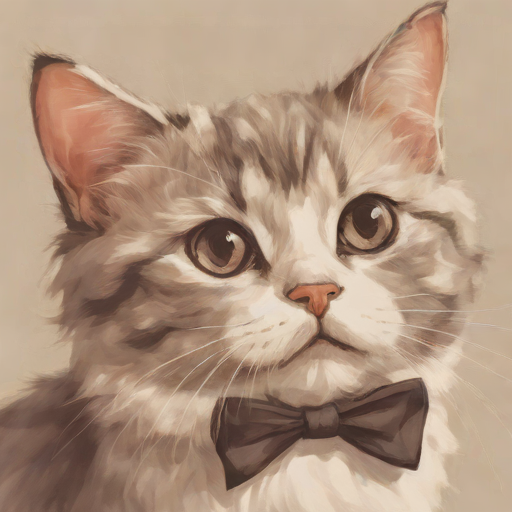

In [9]:
def image_to_tensor(image: Image) -> ov.Tensor:
    pic = image.convert("RGB")
    image_data = np.array(pic.getdata()).reshape(1, pic.size[1], pic.size[0], 3).astype(np.uint8)
    return ov.Tensor(image_data)


init_image = image_to_tensor(image)
photo_prompt = "a cute cat with bow tie"

photo_image_tensor = image2image_pipe.generate(
    photo_prompt,
    image=init_image,
    num_inference_steps=3,
    generator=ov_genai.TorchGenerator(60),
    guidance_scale=0.0,
    strength=0.7,
)
photo_image = Image.fromarray(photo_image_tensor.data[0])
photo_image.save("cat_tie.png")
photo_image

In [10]:
del image2image_pipe
gc.collect();

## Quantization
[back to top ⬆️](#Table-of-contents:)


[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `SDXL-Turbo Model` structure, the UNet model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the SDXL pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [11]:
from notebook_utils import quantization_widget

skip_for_device = "GPU" in device.value
to_quantize = quantization_widget(not skip_for_device)
to_quantize

Checkbox(value=True, description='Quantization')

In [12]:
# Fetch `skip_kernel_extension` module
import requests

if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

int8_pipe = None

core = ov.Core()

%load_ext skip_kernel_extension

We will create another one copy of the models and then replace `unet` model by quantized.

In [ ]:
%%skip not $to_quantize.value

import os
import shutil


model_dir_int8 =  Path("./model_int8")
UNET_INT8_OV_PATH = model_dir_int8 / "unet" / "openvino_model.xml"


if not model_dir_int8.exists():
    shutil.copytree(model_dir, model_dir_int8)
    os.remove(UNET_INT8_OV_PATH)  # remove to replace by optimised

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)


We use a portion of [conceptual_captions](https://huggingface.co/datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [15]:
%%skip not $to_quantize.value


def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {"disable": disable}
    else:
        pipeline._progress_bar_config["disable"] = disable

In [16]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List

set_seed(1)

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []

    def __call__(self, *args, **kwargs):
        self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(pipe, subset_size: int) -> List[Dict]:
    original_unet = pipe.unet.request
    pipe.unet.request = CompiledModelDecorator(original_unet)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    disable_progress_bar(pipe)

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > pipe.tokenizer.model_max_length:
            continue
        _ = pipe(
            prompt,
            num_inference_steps=1,
            height=512,
            width=512,
            guidance_scale=0.0,
            generator=np.random.RandomState(987)
        )
        collected_subset_size = len(pipe.unet.request.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    calibration_dataset = pipe.unet.request.data_cache
    disable_progress_bar(pipe, disable=False)
    pipe.unet.request = original_unet
    return calibration_dataset

In [17]:
%%skip not $to_quantize.value

from optimum.intel.openvino import OVStableDiffusionXLPipeline


if not UNET_INT8_OV_PATH.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
    unet_calibration_data = collect_calibration_data(text2image_pipe, subset_size=200)

  0%|          | 0/200 [00:00<?, ?it/s]

### Run quantization
[back to top ⬆️](#Table-of-contents:)


Create a quantized model from the pre-trained converted OpenVINO model. Quantization of the first and last `Convolution` layers impacts the generation results. We recommend using `IgnoredScope` to keep accuracy sensitive `Convolution` layers in FP16 precision.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [18]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope

UNET_OV_PATH = model_dir / "unet" / "openvino_model.xml"
if not UNET_INT8_OV_PATH.exists():
    unet = core.read_model(UNET_OV_PATH)
    quantized_unet = nncf.quantize(
        model=unet,
        model_type=nncf.ModelType.TRANSFORMER,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        ignored_scope=IgnoredScope(
            names=[
                "__module.model.conv_in/aten::_convolution/Convolution",
                "__module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Convolution",
                "__module.model.conv_out/aten::_convolution/Convolution"
            ],
        ),
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

Output()

Output()

INFO:nncf:3 ignored nodes were found by names in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 6 __module.model.conv_in/aten::_convolution/Convolution
12 __module.model.conv_in/aten::_convolution/Add

INFO:nncf:Not adding activation input quantizer for operation: 308 __module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Convolution
461 __module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Add

INFO:nncf:Not adding activation input quantizer for operation: 800 __module.model.conv_out/aten::_convolution/Convolution
885 __module.model.conv_out/aten::_convolution/Add



Output()

Output()

Let us check predictions with the quantized UNet using the same input data.

In [45]:
%%skip not $to_quantize.value

text2image_pipe_int8 = ov_genai.Text2ImagePipeline(model_dir_int8, device=device.value)

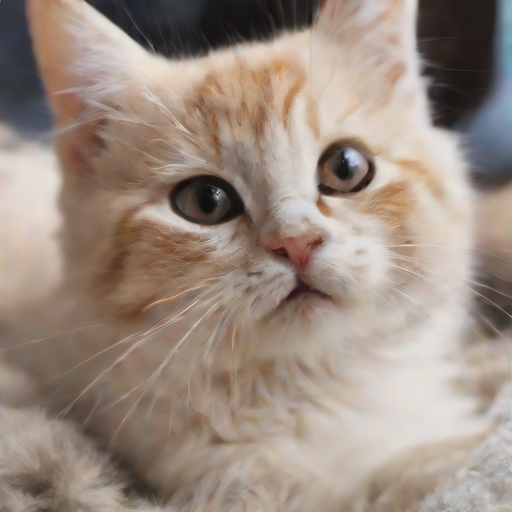

In [46]:
%%skip not $to_quantize.value

prompt = "cute cat"
image_tensor = text2image_pipe_int8.generate(
    prompt,
    num_inference_steps=1,
    height=512,
    width=512,
    guidance_scale=0.0,
    generator=ov_genai.TorchGenerator(987),
)
image = Image.fromarray(image_tensor.data[0])
image.save("cat.png")
display(image)

In [47]:
%%skip not $to_quantize.value


image2image_pipe_int8 = ov_genai.Image2ImagePipeline(model_dir_int8, device=device.value)

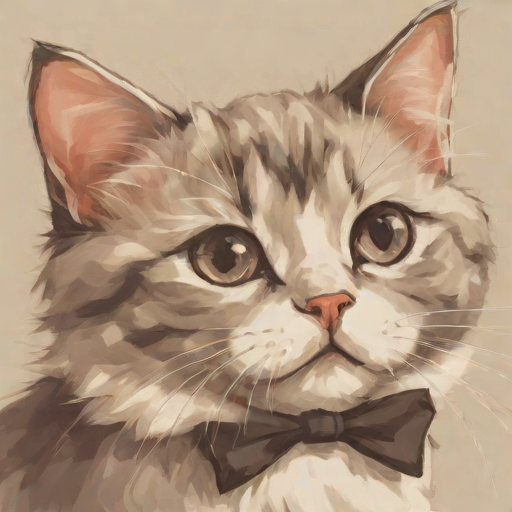

In [48]:
%%skip not $to_quantize.value


init_image = image_to_tensor(image)
photo_prompt = "a cute cat with bow tie"

photo_image_tensor = image2image_pipe_int8.generate(
    photo_prompt,
    image=init_image,
    num_inference_steps=3,
    generator=ov_genai.TorchGenerator(60),
    guidance_scale=0.0,
    strength=0.7,
)
photo_image = Image.fromarray(photo_image_tensor.data[0])
photo_image.save("cat_tie.png")
display(photo_image)

In [49]:
%%skip not $to_quantize.value

del image2image_pipe_int8
gc.collect();

#### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)


In [50]:
%%skip not $to_quantize.value


UNET_OV_PATH = model_dir / "unet" / "openvino_model.bin"
UNET_INT8_OV_PATH = model_dir_int8 / "unet" / "openvino_model.bin"
fp16_ir_model_size = UNET_OV_PATH.stat().st_size / 1024
quantized_model_size = UNET_INT8_OV_PATH.stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 5014578.44 KB
INT8 model size: 2517944.67 KB
Model compression rate: 1.992


### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)


To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [51]:
%%skip not $to_quantize.value

import time

validation_size = 7
calibration_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True)
validation_data = []
for batch in calibration_dataset:
    prompt = batch["caption"]
    validation_data.append(prompt)

def calculate_inference_time(pipe, dataset):
    inference_time = []

    for idx, prompt in enumerate(dataset):
        start = time.perf_counter()
        image_tensor = pipe.generate(
            prompt,
            num_inference_steps=1,
            guidance_scale=0.0,
            generator=ov_genai.TorchGenerator(23),
        )
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
        if idx >= validation_size:
            break
    return np.median(inference_time)

In [52]:
%%skip not $to_quantize.value

int8_latency = calculate_inference_time(text2image_pipe_int8, validation_data)
text2image_pipe = ov_genai.Text2ImagePipeline(model_dir, device.value)
fp_latency = calculate_inference_time(text2image_pipe, validation_data)
print(f"FP16 pipeline latency: {fp_latency:.3f}")
print(f"INT8 pipeline latency: {int8_latency:.3f}")
print(f"Text-to-Image generation speed up: {fp_latency / int8_latency:.3f}")

FP16 pipeline latency: 2.387
INT8 pipeline latency: 1.846
Text-to-Image generation speed up: 1.293


In [53]:
%%skip not $to_quantize.value

del text2image_pipe_int8
del text2image_pipe
gc.collect();

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)


Now, you can check model work using own text descriptions. Provide text prompt in the text box and launch generation using Run button. Additionally you can control generation with additional parameters:
* Seed - random seed for initialization
* Steps - number of generation steps
* Height and Width - size of generated image

> Please note that increasing image size may require to increasing number of steps for accurate result. We recommend running 104x1024 resolution image generation using 4 steps.

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [54]:
import ipywidgets as widgets

quantized_model_present = UNET_INT8_OV_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=False,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [57]:
if use_quantized_model.value:
    if not quantized_model_present:
        raise RuntimeError("Quantized model not found.")
    text2image_pipe = ov_genai.Text2ImagePipeline(model_dir_int8, device=device.value)
else:
    text2image_pipe = ov_genai.Text2ImagePipeline(model_dir, device=device.value)


def generate_from_text(text, seed, num_steps, height, width):
    image_tensor = text2image_pipe.generate(
        text,
        num_inference_steps=num_steps,
        guidance_scale=0.0,
        generator=ov_genai.TorchGenerator(seed),
        height=height,
        width=width,
    )
    image = Image.fromarray(image_tensor.data[0])

    return image

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/sdxl-turbo/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=generate_from_text, quantized=use_quantized_model.value)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/